In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy

# Import additional utilities
from dataclasses import dataclass, field  # Ensure 'field' is imported
from einops import rearrange, repeat
from typing import Union

import math

In [16]:

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [17]:
@dataclass
class ModelArgs:
# Thông tin đầu vào
    model_input_dims: int = 63  # 21 keypoints x 3 tọa độ (x, y, z)
    seq_length: int = 60  # Độ dài chuỗi keypoints (60 khung hình mỗi mẫu)

    # Kiến trúc mô hình
    model_states: int = 64  # Số trạng thái trong không gian ẩn của Mamba block
    projection_expand_factor: int = 2  # Hệ số mở rộng khi chiếu sang không gian khác
    conv_kernel_size: int = 4  # Kích thước kernel cho Conv1D trong Mamba block
    num_layers: int = 5  # Số lượng Residual Blocks
    dropout_rate: float = 0.2  # Tỷ lệ dropout để tránh overfitting
    
    conv_use_bias: bool = True
    dense_use_bias: bool = False

    # Tham số liên quan đến tính toán Delta-t
    delta_t_min: float = 0.001  # Giá trị tối thiểu cho Delta-t
    delta_t_max: float = 0.1  # Giá trị tối đa cho Delta-t
    delta_t_scale: float = 0.1  # Hệ số scale cho Delta-t
    delta_t_init_floor: float = 1e-4  # Giá trị khởi tạo sàn cho Delta-t
    delta_t_rank: int = 4  # Xác định thứ hạng (rank) trong Delta-t (tự động tính theo input_dims)
    
    # Hàm kích hoạt và thông tin đầu ra
    num_classes: int = 8  # Số nhãn (Forward, Stop, Up, Down, ...)
    final_activation: str = "softmax"  # Hàm kích hoạt cho đầu ra
    loss: Union[str, keras.losses.Loss] = "categorical_crossentropy"  # Hàm loss
    metrics = ['accuracy']  # Danh sách các metric để đánh giá

    # Tối ưu hóa
    optimizer: Union[str, keras.optimizers.Optimizer] = keras.optimizers.AdamW(learning_rate=1e-3)

    # Giá trị mặc định hoặc kiểm tra
    def __post_init__(self):
        # Số chiều không gian ẩn (nội bộ)
        self.model_internal_dim: int = int(self.projection_expand_factor * self.model_input_dims)
        
        # Tự động tính toán Delta-t rank nếu chưa được đặt
        self.delta_t_rank = math.ceil(self.model_input_dims / 16)
        
        # Kiểm tra số lớp đầu ra
        if self.num_classes <= 1:
            raise ValueError(f"num_classes phải lớn hơn 1, hiện tại là {self.num_classes}")
        
        # Đảm bảo có hàm loss
        if self.loss is None:
            raise ValueError("loss không thể là None")

    # Add a method to convert to a dictionary (this is required for serialization)
    def to_dict(self):
        return {
            "model_input_dims": self.model_input_dims,
            "seq_length": self.seq_length,
            "model_states": self.model_states,
            "projection_expand_factor": self.projection_expand_factor,
            "conv_kernel_size": self.conv_kernel_size,
            "num_layers": self.num_layers,
            "dropout_rate": self.dropout_rate,
            "conv_use_bias": self.conv_use_bias,
            "dense_use_bias": self.dense_use_bias,
            "delta_t_min": self.delta_t_min,
            "delta_t_max": self.delta_t_max,
            "delta_t_scale": self.delta_t_scale,
            "delta_t_init_floor": self.delta_t_init_floor,
            "delta_t_rank": self.delta_t_rank,
            "num_classes": self.num_classes,
            "final_activation": self.final_activation,
            "loss": self.loss,
            "metrics": self.metrics,
            "optimizer": self.optimizer,
        }

    # You can then modify the `get_config` of the custom layer as follows:
    def get_config(self):
        config = super().get_config()
        config.update({
            "modelargs": self.args.to_dict()  # Serialize ModelArgs as a dictionary
        })
        return config


In [18]:
def selective_scan(u, delta, A, B, C, D):
    dA = tf.einsum('bld,dn->bldn', delta, A) # first step of A_bar = exp(ΔA), i.e., ΔA
    dB_u = tf.einsum('bld,bld,bln->bldn', delta, u, B)
    
    dA_cumsum = tf.pad(
        dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :]
    
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip along axis 1
    
    # Cumulative sum along all the input tokens, parallel prefix sum, calculates dA for all the input tokens parallely
    dA_cumsum = tf.math.cumsum(dA_cumsum, axis=1)  
    dA_cumsum = tf.exp(dA_cumsum)  # second step of A_bar = exp(ΔA), i.e., exp(ΔA)
    
    dA_cumsum = tf.reverse(dA_cumsum, axis=[1])  # Flip back along axis 1

    x = dB_u * dA_cumsum
    x = tf.math.cumsum(x, axis=1)/(dA_cumsum + 1e-12) # 1e-12 to avoid division by 0

    y = tf.einsum('bldn,bln->bld', x, C)
    
    return y + u * D 

In [19]:
class MambaBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs

        self.in_projection = layers.Dense(
            args.model_internal_dim * 2, 
            input_shape=(args.model_input_dims,), 
            use_bias=False)

        self.conv1d = layers.Conv1D(
            filters=args.model_internal_dim,
            use_bias=args.conv_use_bias,
            kernel_size=args.conv_kernel_size,
            groups=args.model_internal_dim,
            data_format='channels_first',
            padding='causal'
        )

        # this layer takes in current token 'x' and outputs the input-specific Δ, B, C (according to S6)
        self.x_projection = layers.Dense(
            args.delta_t_rank + args.model_states * 2, 
            use_bias=False)

        # this layer projects Δ from delta_t_rank to the mamba internal dimension
        self.delta_t_projection = layers.Dense(args.model_internal_dim, 
                                               input_shape=(args.delta_t_rank,), use_bias=True)

        self.A = tf.Variable(repeat(
                tf.range(1, args.model_states+1, dtype=tf.float32), 
                'n -> d n', d=args.model_internal_dim), trainable=False, dtype=tf.float32)
        self.A_log = tf.Variable(tf.math.log(self.A), trainable=True, dtype=tf.float32)

        self.D = tf.Variable(np.ones(args.model_internal_dim), dtype=tf.float32)

        self.out_projection = layers.Dense(
            args.model_input_dims, 
            input_shape=(args.model_internal_dim,), use_bias=args.dense_use_bias)

    def call(self, x):

        (batch_size, seq_len, dimension) = x.shape

        x_and_res = self.in_projection(x) # shape = (batch, seq_len, 2 * model_internal_dimension)
        (x, res) = tf.split(x_and_res, 
                            [self.args.model_internal_dim, self.args.model_internal_dim], axis=-1)
        
        x = rearrange(x, 'b l d_in -> b d_in l') 
        x = self.conv1d(x)[:, :, :seq_len] 
        x = rearrange(x, 'b d_in l -> b l d_in') 
        
        x = tf.nn.swish(x) 
        y = self.ssm(x) 
        y = y * tf.nn.swish(res) # right side of mamba block image
        return self.out_projection(y)
    
    def ssm(self, x):

        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -tf.exp(tf.cast(self.A_log, tf.float32)) # shape -> (d_in, n)
        D = tf.cast(self.D, tf.float32)

        x_dbl = self.x_projection(x) # shape -> (batch, seq_len, delta_t_rank + 2*n)

        
        (delta, B, C) = tf.split(
            x_dbl, 
            num_or_size_splits=[self.args.delta_t_rank, n, n], 
            axis=-1) # delta.shape -> (batch, seq_len) & B, C shape -> (batch, seq_len, n)

        delta = tf.nn.softplus(
            self.delta_t_projection( delta)) # shape -> (batch, seq_len, model_input_dim)

        return selective_scan(x, delta, A, B, C, D)


In [20]:
class ResidualBlock(layers.Layer):
    def __init__(self, modelargs: ModelArgs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = modelargs
        args = modelargs

        self.mixer = MambaBlock(args)
        self.norm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, x):
        return self.mixer(self.norm(x)) + x
    def get_config(self):
        # Convert ModelArgs to a dictionary (for serialization)
        config = super().get_config()
        config.update({
            'modelargs': self.args.to_dict()  # Assuming ModelArgs has to_dict() method
        })
        return config

In [21]:
def init_model(args: ModelArgs):
    """
    Hàm khởi tạo mô hình Mamba-SSM cho bài toán nhận diện cử chỉ tay.
    """
    # Đầu vào là một chuỗi tọa độ các điểm tay (seq_length, model_input_dims)
    input_layer = layers.Input(shape=(args.seq_length, args.model_input_dims), name='hand_gesture_input')

    # Xây dựng các lớp ResidualBlock
    x = input_layer
    for i in range(args.num_layers):
        x = ResidualBlock(args, name=f"Residual_{i}")(x)  # Residual block
        x = layers.Dropout(args.dropout_rate, name=f"Dropout_{i}")(x)  # Dropout

    # Chuẩn hóa sau khi đi qua các lớp ResidualBlock
    x = layers.LayerNormalization(epsilon=1e-5, name="LayerNorm_Final")(x)

    # Kết hợp đặc trưng theo trục chuỗi (Flatten hoặc Global Average Pooling)
    if args.seq_length > 1:
        x = layers.Flatten(name="Flatten")(x)

    # Fully connected layer với kích thước cố định
    x = layers.Dense(1024, activation=tf.nn.gelu, name="Dense_Intermediate")(x)

    # Lớp đầu ra với số lớp phân loại là num_classes
    output_layer = layers.Dense(args.num_classes, activation=args.final_activation, name="Output_Layer")(x)

    # Khởi tạo mô hình
    model = keras.Model(inputs=input_layer, outputs=output_layer, name="Mamba_Hand_Gesture_Model")
    
    # Biên dịch mô hình với các tham số từ args
    model.compile(
        loss=args.loss,
        optimizer=args.optimizer,
        metrics=args.metrics
    )

    return model


In [22]:
args = ModelArgs(
    model_input_dims=63,  # 21 điểm × 3 tọa độ
    seq_length=30,  # Mỗi chuỗi dài 60 khung hình
    num_classes=8,  # 8 lớp cử chỉ
    loss='categorical_crossentropy',  # Hàm mất mát
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3),  # Tối ưu hóa
    dropout_rate=0.2  # Dropout để tránh overfitting
)


model = init_model(args)
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Mamba_Hand_Gesture_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hand_gesture_input (InputLayer) │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Residual_0 (ResidualBlock)      │ (None, 30, 63)         │        41,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_0 (Dropout)             │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Residual_1 (ResidualBlock)      │ (None, 30, 63)         │        41,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Residual_2 (ResidualBlock)      │ (None, 30, 63)         │        41,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Residual_3 (ResidualBlock)      │ (None, 30, 63)         │        41,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Residual_4 (ResidualBlock)      │ (None, 30, 63)         │        41,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 30, 63)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LayerNorm_Final                 │ (None, 30, 63)         │           126 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 1890)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Intermediate (Dense)      │ (None, 1024)           │     1,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,153,870 (8.22 MB)

 Trainable params: 2,153,870 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Đọc dữ liệu từ file CSV
file_path = r"C:\Users\Admin\Desktop\project\build data\phi\hand_landmarks.csv"
data = pd.read_csv(file_path)

# Kiểm tra dữ liệu
print("Dữ liệu mẫu:")
data.head()

Dữ liệu mẫu:


,label,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,0,0.429700,0.792350,5.740160e-07,0.501864,0.794989,-0.045809,0.567205,0.729862,-0.074629,...,-0.079666,0.406163,0.431539,-0.108991,0.414071,0.352032,-0.123078,0.423529,0.281127,-0.130939
1,0,0.412696,0.795540,5.284580e-07,0.490001,0.789170,-0.045813,0.557917,0.721280,-0.074538,...,-0.079930,0.388011,0.433379,-0.110877,0.393700,0.351816,-0.125882,0.399744,0.278304,-0.134405
2,0,0.407125,0.790495,5.096039e-07,0.483270,0.787420,-0.049452,0.550412,0.723182,-0.080264,...,-0.082948,0.376442,0.419602,-0.114022,0.383137,0.336990,-0.129662,0.391597,0.263608,-0.139037
3,0,0.403398,0.792842,4.707212e-07,0.479691,0.789677,-0.047579,0.548167,0.724385,-0.077898,...,-0.082775,0.374562,0.425961,-0.112499,0.381641,0.345380,-0.127724,0.389639,0.272101,-0.137517
4,0,0.408421,0.800763,4.574627e-07,0.482303,0.792316,-0.043959,0.548428,0.727208,-0.071517,...,-0.073037,0.379898,0.427413,-0.099823,0.387351,0.347378,-0.112756,0.395781,0.274369,-0.120604


In [24]:
# Tách nhãn và đặc trưng
labels = data['label']  # Cột nhãn
features = data.drop(columns=['label'])  # Bỏ cột nhãn, giữ lại các đặc trưng

# Chuyển đổi nhãn và đặc trưng thành numpy array
labels = labels.to_numpy()
features = features.to_numpy()

# Kiểm tra kích thước dữ liệu
print(f"Shape of features: {features.shape}, labels: {labels.shape}")


Shape of features: (11734, 63), labels: (11734,)


In [25]:
# Hàm tạo chuỗi từ dữ liệu phẳng
def create_sequences(features, labels, seq_length=60):
    sequences = []
    sequence_labels = []
    for i in range(len(features) - seq_length + 1):
        sequence = features[i:i + seq_length]
        label = labels[i + seq_length - 1]  # Gán nhãn cho chuỗi là nhãn của khung cuối
        sequences.append(sequence)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

# Tạo dữ liệu chuỗi
seq_length = 30
X_sequences, y_sequences = create_sequences(features, labels, seq_length)

# Kiểm tra kích thước sau khi tạo chuỗi
print(f"Shape of sequences: {X_sequences.shape}, sequence labels: {y_sequences.shape}")

Shape of sequences: (11705, 30, 63), sequence labels: (11705,)


In [26]:
# Chia tập dữ liệu thành train/test/validation
X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (9364, 30, 63)
Validation set size: (1170, 30, 63)
Test set size: (1171, 30, 63)


In [27]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()

# Đưa dữ liệu về dạng phẳng để chuẩn hóa
X_train = X_train.reshape(-1, X_train.shape[-1])
X_val = X_val.reshape(-1, X_val.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

# Áp dụng chuẩn hóa
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Đưa dữ liệu về dạng chuỗi
X_train = X_train.reshape(-1, seq_length, X_sequences.shape[-1])
X_val = X_val.reshape(-1, seq_length, X_sequences.shape[-1])
X_test = X_test.reshape(-1, seq_length, X_sequences.shape[-1])

# Chuyển nhãn thành dạng one-hot (nếu chưa)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=8)

# Hàm tạo TensorFlow Dataset
def create_tf_dataset(features, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Tạo TensorFlow Dataset
batch_size = 32
train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_tf_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)
print(X_train.shape)
print("Dữ liệu đã sẵn sàng để huấn luyện!")

(9364, 30, 63)
Dữ liệu đã sẵn sàng để huấn luyện!


In [28]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.8503 - loss: 0.4917 - val_accuracy: 0.9932 - val_loss: 0.1122
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.9853 - loss: 0.0544 - val_accuracy: 0.9957 - val_loss: 0.0540
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.9921 - loss: 0.0386 - val_accuracy: 0.9932 - val_loss: 0.0410
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 826s 3s/step - accuracy: 0.9933 - loss: 0.0355 - val_accuracy: 0.9966 - val_loss: 0.0813
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 765s 3s/step - accuracy: 0.9927 - loss: 0.0318 - val_accuracy: 0.9966 - val_loss: 0.0675
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.9949 - loss: 0.0222 - val_accuracy: 0.9915 - val_loss: 0.0575
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.9916 - loss: 0.0579 - val_accuracy: 0.9957 - val_loss: 0.0696
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.9961 - loss: 0.0159 - val_accu

In [29]:
# Đánh giá mô hình
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Lưu mô hình vào file .keras
model.save('hand_action_model.keras')
print("Mô hình đã được lưu vào file")

37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9814 - loss: 0.3993
Test Loss: 0.2083, Test Accuracy: 0.9898
Mô hình đã được lưu vào file


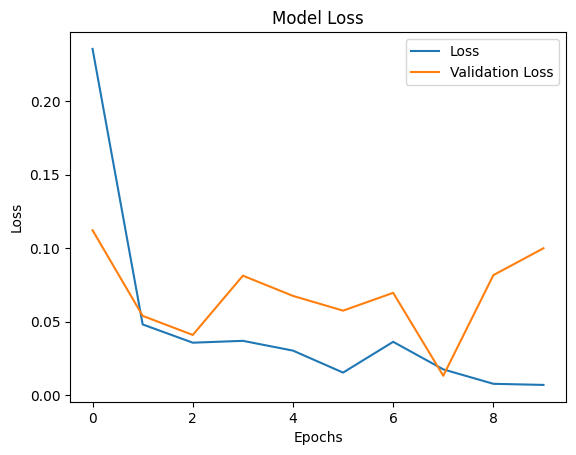

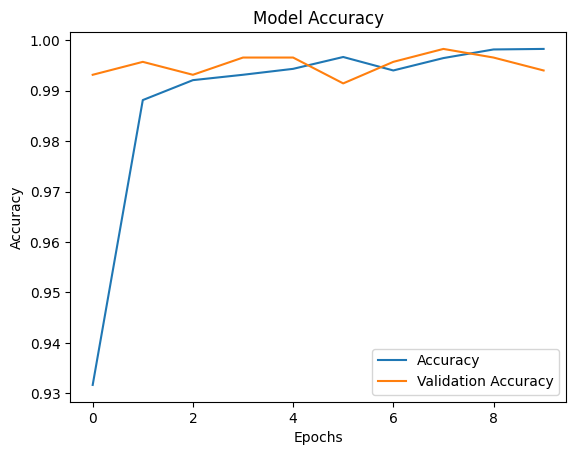

In [30]:
import matplotlib.pyplot as plt

# Vẽ đồ thị của loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị của accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
